# Import

In [1]:
import os
import sys

import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import datetime
import time
from IPython.display import clear_output

import pytransform3d.rotations as pr
from pytransform3d.plot_utils import make_3d_axis
from scipy.spatial.transform import Rotation as R
from utils import *

from grace.utils import *

# Initialization

In [2]:
calib_params = load_json('config/calib/calib_params.json')

pan_direction: {
    0: 'left_left',
    1: 'left_right',
    2: 'right_left',
    3: 'right_right',
}
    
tilt_direction: {
    0: 'down_down',
    1: 'down_up',
    2: 'up_down',
    3: 'up_up',
}
    
chessboard_size = (9,6)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#7fff00', '#d2b48c', '#000080']

def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def get_phi_direction(theta, theta_tminus1, data, i):
    phi_direction = None
    try:
        if data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 0
        elif data[theta][i-1]<data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 1
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]<data[theta_tminus1][i]:
            phi_direction = 2
        elif data[theta][i-1]>=data[theta_tminus1][i-1] and data[theta][i]>=data[theta_tminus1][i]:
            phi_direction = 3
    except:
        phi_direction = 0
    return phi_direction

def get_chess_corners(img, camera_mtx, dist_coef):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    
    # Subcorner Pixel Accuracy
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv2.cornerSubPix(gray, corners, (9,9), (-1,-1), criteria)
    corners = corners.squeeze()
    
    return corners

def get_chess_obj_pts(img, depth_img, camera_mtx, dist_coef):
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    int_corners = np.round(corners).astype(int)
    
    depth_list = []
    for corner in int_corners:
        depth_list.append(depth_img[corner[1], corner[0]])
    depth_list = np.array(depth_list)
    depth_mean = np.mean(depth_list[np.nonzero(depth_list)])/1000.0
    
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]

    obj_pts = []
    for i,(u,v) in enumerate(corners):
        z = depth_list[i]/1000.0
        if z==0:
            z = depth_mean
        x = ((u-cx)/fx)*z
        y = ((v-cy)/fy)*z
        obj_pts.append([x, y, z])
        
    return np.array(obj_pts)

def get_camera_pose(img, obj_pts, camera_mtx, dist_coef):
    # Get corners
    corners = get_chess_corners(img, camera_mtx, dist_coef)
    
    # Estimate the extrinsic matrix
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef)
    retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, flags=cv2.SOLVEPNP_SQPNP )
    # retval, rvec, tvec = cv2.solvePnP(obj_pts, corners, camera_mtx, dist_coef, rvec, tvec=np.array([0,0,0.25]), useExtrinsicGuess = True)
    
    # Convert the rotation vector to a rotation matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    
    # Homogeneous Coordinates
    H = np.eye(4)
    H[:3,:3] = rotation_matrix
    H[:3,-1] = tvec.T
    
    # Camera Pose
    T = np.linalg.inv(H)
    return T
    
def depth_to_pointcloud(px, depth_img, camera_mtx, z_replace):  
    fx = camera_mtx[0][0]
    cx = camera_mtx[0][2]
    fy = camera_mtx[1][1]
    cy = camera_mtx[1][2]
    u = round(px[0])
    v = round(px[1])
    z = depth_img[v,u]/1000.0
    if z==0:
        z = z_replace
    x = ((u-cx)/fx)*z
    y = ((v-cy)/fy)*z
    return x,y,z

def transform_points(pts, T_mtx):
    new_obj_pts = []
    for pt in pts:
        temp_pt = np.append(pt, 1).reshape(-1,1)
        temp_pt2 = (T_mtx @ temp_pt).squeeze()
        new_obj_pts.append(temp_pt2[:3])
    new_obj_pts = np.array(new_obj_pts)
    return new_obj_pts

# Loading of Data

## Pickle Data

In [3]:
filename = 'pantilt_baseline_sweep_pickle_20240319_025603_187093.pickle'

In [4]:
fn_path = os.path.join(os.getcwd(), 'results', 'pantilt_baseline_sweep',filename)
data = read_pickle_file(fn_path)
data = data['data']

In [5]:
pickle_df = pd.DataFrame(data)

## Preprocessing



<div class="alert alert-block alert-danger">
<b>Current Issue:</b> Unsynchronized appending for the motor commands. 'theta_left_pan_cmd' is actually 'theta_left_pan_cmd_tminus1'
</div>

In [6]:
# Temporary Solution

In [7]:
filename = "pantilt_baseline_sweep_csv_20240319_025603_187093.csv"
fn_path = os.path.join(os.getcwd(), 'results', 'pantilt_baseline_sweep',filename)
df = pd.read_csv(fn_path)
df['theta_left_pan_cmd']

0      -18
1        0
2      -18
3        1
4      -18
        ..
1817    11
1818   -18
1819    12
1820   -18
1821     0
Name: theta_left_pan_cmd, Length: 1822, dtype: int64

In [8]:
pickle_df['theta_left_pan_cmd'] = df['theta_left_pan_cmd'].values
pickle_df['theta_left_pan_cmd']

0      -18
1        0
2      -18
3        1
4      -18
        ..
1817    11
1818   -18
1819    12
1820   -18
1821     0
Name: theta_left_pan_cmd, Length: 1822, dtype: int64

In [9]:
pickle_df['theta_right_pan_cmd'] = df['theta_right_pan_cmd'].values
pickle_df['theta_right_pan_cmd']

0       18
1      -12
2       18
3      -11
4       18
        ..
1817    -1
1818    18
1819     0
1820    18
1821   -12
Name: theta_right_pan_cmd, Length: 1822, dtype: int64

In [10]:
pickle_df['theta_tilt_cmd'] = df['theta_tilt_cmd'].values
pickle_df['theta_tilt_cmd']

0        0
1        0
2        0
3        0
4        0
        ..
1817   -30
1818   -30
1819   -30
1820     0
1821     0
Name: theta_tilt_cmd, Length: 1822, dtype: int64

-----------------------------------------------------

In [11]:
# Assigning next step data for tminus1

pickle_df['theta_left_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_left_pan_cmd'][:-2].tolist() 
pickle_df['theta_right_pan_cmd_tminus2'] = [0,0] + pickle_df['theta_right_pan_cmd'][:-2].tolist() 
pickle_df['theta_tilt_cmd_tminus2'] = [0,0] + pickle_df['theta_tilt_cmd'][:-2].tolist()
pickle_df['theta_left_pan_cmd_tminus1'] = [0] + pickle_df['theta_left_pan_cmd'][:-1].tolist() 
pickle_df['theta_right_pan_cmd_tminus1'] = [0] + pickle_df['theta_right_pan_cmd'][:-1].tolist() 
pickle_df['theta_tilt_cmd_tminus1'] = [0] + pickle_df['theta_tilt_cmd'][:-1].tolist()
pickle_df['chess_idx_tminus1'] = [0] + pickle_df['chess_idx'][:-1].tolist() 
pickle_df['theta_left_pan_tminus1'] = [0] + pickle_df['theta_left_pan'][:-1].tolist() 
pickle_df['theta_right_pan_tminus1'] = [0] + pickle_df['theta_right_pan'][:-1].tolist() 
pickle_df['theta_tilt_tminus1'] = [0] + pickle_df['theta_tilt'][:-1].tolist()
pickle_df['plan_phi_left_pan_tminus2'] = [0,0] + pickle_df['plan_phi_left_pan'][:-2].tolist()
pickle_df['plan_phi_right_pan_tminus2'] = [0,0] + pickle_df['plan_phi_right_pan'][:-2].tolist()
pickle_df['plan_phi_tilt_tminus2'] = [0,0] + pickle_df['plan_phi_tilt'][:-2].tolist()
pickle_df['plan_phi_left_pan_tminus1'] = [0] + pickle_df['plan_phi_left_pan'][:-1].tolist()
pickle_df['plan_phi_right_pan_tminus1'] = [0] + pickle_df['plan_phi_right_pan'][:-1].tolist()
pickle_df['plan_phi_tilt_tminus1'] = [0] + pickle_df['plan_phi_tilt'][:-1].tolist()

In [12]:
# Phi Direction

phi_direction_left_pan_list = [0] + [get_phi_direction(theta='plan_phi_left_pan_tminus1',
                                                       theta_tminus1='plan_phi_left_pan_tminus2',
                                                       data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_right_pan_list = [0] + [get_phi_direction(theta='plan_phi_right_pan_tminus1',
                                                        theta_tminus1='plan_phi_right_pan_tminus2',
                                                        data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]
phi_direction_tilt_list = [0] + [get_phi_direction(theta='plan_phi_tilt_tminus1',
                                                   theta_tminus1='plan_phi_tilt_tminus2',
                                                   data=pickle_df, i=i) 
                                     for i in range(1, len(pickle_df))]

pickle_df['phi_direction_left_pan'] = phi_direction_left_pan_list
pickle_df['phi_direction_right_pan'] = phi_direction_right_pan_list
pickle_df['phi_direction_tilt'] = phi_direction_tilt_list

In [13]:
pickle_df.columns

Index(['chess_idx', 'theta_left_pan', 'theta_right_pan', 'theta_tilt',
       'chest_cam_px_x_tminus1', 'chest_cam_px_y_tminus1',
       'left_eye_px_x_tminus1', 'left_eye_px_y_tminus1',
       'right_eye_px_x_tminus1', 'right_eye_px_y_tminus1', 'chest_cam_px_x',
       'chest_cam_px_y', 'left_eye_px_x', 'left_eye_px_y', 'right_eye_px_x',
       'right_eye_px_y', 'dx_l', 'dy_l', 'dx_r', 'dy_r', '3d_point',
       'chest_pan_angle', 'chest_tilt_angle', 'plan_phi_left_pan',
       'plan_phi_right_pan', 'plan_phi_tilt', 'chest_img', 'left_eye_img',
       'right_eye_img', 'depth_img', 'chest_img_stamp', 'left_eye_img_stamp',
       'right_eye_img_stamp', 'depth_img_stamp', 'theta_left_pan_cmd',
       'theta_right_pan_cmd', 'theta_tilt_cmd', 'theta_left_pan_cmd_tminus2',
       'theta_right_pan_cmd_tminus2', 'theta_tilt_cmd_tminus2',
       'theta_left_pan_cmd_tminus1', 'theta_right_pan_cmd_tminus1',
       'theta_tilt_cmd_tminus1', 'chess_idx_tminus1', 'theta_left_pan_tminus1',
       't

In [14]:
# Dropping the first row
pickle_df = pickle_df.drop(np.arange(0,2)).reset_index(drop=True)
pickle_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.439453,-11.689453,0.263672,374.414001,82.588356,345.086884,210.130737,342.594421,221.538406,...,0.263672,-0.191229,-0.258835,-0.045053,-0.077717,-0.138835,-0.008162,1,1,1
1,6,-16.875000,16.962891,0.263672,439.533752,81.984497,-360.600000,-224.700000,-222.300000,-235.900000,...,0.263672,-0.077717,-0.138835,-0.008162,0.041399,-0.020434,-0.006353,3,3,3
2,8,0.527344,-10.634766,0.263672,504.468689,80.883873,457.309296,211.922394,452.888855,225.842072,...,0.263672,0.041399,-0.020434,-0.006353,0.155831,0.094958,-0.004544,3,3,3
3,6,-16.787109,16.962891,0.263672,569.306274,80.087906,-360.600000,-224.700000,-222.300000,-235.900000,...,0.263672,0.155831,0.094958,-0.004544,0.272865,0.206433,-0.036638,3,3,2
4,4,1.494141,-9.667969,0.263672,504.454498,80.909485,439.733765,211.911316,432.642273,225.656754,...,0.263672,0.272865,0.206433,-0.036638,0.155831,0.094958,-0.004544,2,2,1


# Filtering

In [15]:
filt_df = pickle_df[(pickle_df['theta_left_pan_cmd_tminus1']>-13) & (pickle_df['theta_left_pan_cmd_tminus1']<13) ].reset_index(drop=True)
filt_df.head()

,chess_idx,theta_left_pan,theta_right_pan,theta_tilt,chest_cam_px_x_tminus1,chest_cam_px_y_tminus1,left_eye_px_x_tminus1,left_eye_px_y_tminus1,right_eye_px_x_tminus1,right_eye_px_y_tminus1,...,theta_tilt_tminus1,plan_phi_left_pan_tminus2,plan_phi_right_pan_tminus2,plan_phi_tilt_tminus2,plan_phi_left_pan_tminus1,plan_phi_right_pan_tminus1,plan_phi_tilt_tminus1,phi_direction_left_pan,phi_direction_right_pan,phi_direction_tilt
0,4,-0.439453,-11.689453,0.263672,374.414001,82.588356,345.086884,210.130737,342.594421,221.538406,...,0.263672,-0.191229,-0.258835,-0.045053,-0.077717,-0.138835,-0.008162,1,1,1
1,8,0.527344,-10.634766,0.263672,504.468689,80.883873,457.309296,211.922394,452.888855,225.842072,...,0.263672,0.041399,-0.020434,-0.006353,0.155831,0.094958,-0.004544,3,3,3
2,4,1.494141,-9.667969,0.263672,504.454498,80.909485,439.733765,211.911316,432.642273,225.656754,...,0.263672,0.272865,0.206433,-0.036638,0.155831,0.094958,-0.004544,2,2,1
3,0,2.548828,-8.701172,0.263672,374.422882,82.572838,297.115875,209.764938,288.430573,220.642685,...,0.263672,0.041399,-0.020434,-0.006353,-0.077717,-0.138835,-0.008162,0,0,0
4,4,3.427734,-7.734375,0.263672,374.414337,82.587730,282.446960,209.609833,270.950470,220.320724,...,0.263672,-0.191072,-0.259080,-0.046732,-0.077717,-0.138835,-0.008162,1,1,1


In [16]:
print(filt_df['theta_left_pan_cmd_tminus1'].unique())
print(filt_df['theta_right_pan_cmd_tminus1'].unique())
print(filt_df['theta_tilt_cmd_tminus1'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0]
[  0  -5 -10 -15 -20 -25 -30]


# Extrinsic Matrix

## Initialization

In [17]:
calib_params = load_json('config/calib/calib_params.json')
camera_mtx = load_json("config/camera/camera_mtx.json")

In [18]:
left_eye_camera_mtx = np.array(camera_mtx['left_eye']['camera_matrix'])
left_eye_dist_coef = np.array(camera_mtx['left_eye']['distortion_coefficients']).squeeze()
right_eye_camera_mtx = np.array(camera_mtx['right_eye']['camera_matrix'])
right_eye_dist_coef = np.array(camera_mtx['right_eye']['distortion_coefficients']).squeeze()
chest_cam_camera_mtx = np.array(camera_mtx['chest_cam']['camera_matrix'])
chest_cam_dist_coef = np.array(camera_mtx['chest_cam']['distortion_coefficients']).squeeze()

In [19]:
# Example

chest_img = filt_df['chest_img'][0]
depth_img = filt_df['depth_img'][0]

In [20]:
# Get Chess Corners

corners = get_chess_corners(chest_img, chest_cam_camera_mtx, chest_cam_dist_coef)

In [21]:
# Define the 3D coordinates of the chessboard corners in the world coordinate system
chessboard_size = (9, 6)
origin_point = [0,0]
square_size = 0.0467  # Assumiimgng each square size is 1 unit
obj_pts = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
obj_pts[:,:2] = (np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) -np.array(origin_point))* square_size

(300.0, 40.0)

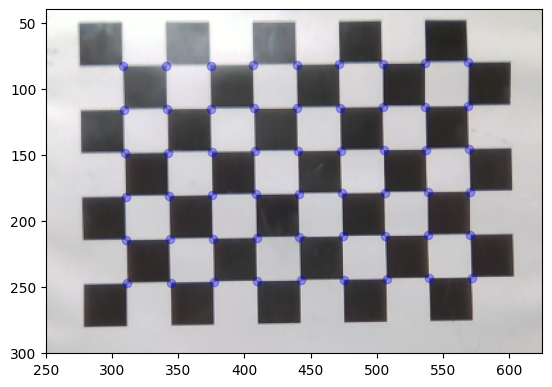

In [22]:
plt.figure()
plt.imshow(chest_img)
for u,v in corners:
    plt.scatter(u,v, color='blue',alpha=0.3)
plt.xlim([250, 625])
plt.ylim([300, 40])

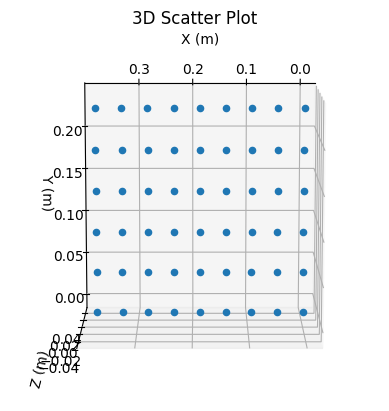

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and an axes object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
for x,y,z in obj_pts:
    ax.scatter(x, y, z, color=colors[0])

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Scatter Plot')
#ax.set_zlim([-0.2,1.7])
ax.view_init(elev=-80, azim=90)

# Show the plot
plt.show()

# Chess Point Location Transformation (Chess World -> Chest)

In [24]:
# Transformation for the shifting of the center

T_chest_cam_ctr = np.eye(4)
T_chest_cam_ctr[0, -1] = -0.0325  # chest rgb to module center, 32.5 mm
T_chest_cam_ctr

array([[ 1.    ,  0.    ,  0.    , -0.0325],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [25]:
# Transformation for the shifting of the center

T_chest_depth_cam_ctr = np.eye(4)
T_chest_depth_cam_ctr[0, -1] = -0.0325  # chest rgb to module center, 32.5 mm
T_chest_depth_cam_ctr[2, -1] = -0.0042  # Z value offset to realsense glass
T_chest_depth_cam_ctr

array([[ 1.    ,  0.    ,  0.    , -0.0325],
       [ 0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    , -0.0042],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

# Extrinsic Transformation (Left)

In [26]:
# Chest Image

T_chest = get_camera_pose(chest_img, obj_pts, chest_cam_camera_mtx, chest_cam_dist_coef)

In [27]:
# Looping: Left Eye Image

img_list = filt_df['left_eye_img'].tolist()
T_left_list = []
for img in img_list:
    T_left_list.append(get_camera_pose(img, obj_pts, left_eye_camera_mtx, left_eye_dist_coef))

# Gaze Center Calculation

In [28]:
# Left Eye

gx_left = calib_params['left_eye']['x_center']
gy_left = calib_params['left_eye']['y_center']

fx_left = left_eye_camera_mtx[0][0]
cx_left = left_eye_camera_mtx[0][2]
fy_left = left_eye_camera_mtx[1][1]
cy_left = left_eye_camera_mtx[1][2]

print('gx_left:', gx_left)
print('cx_left:',cx_left)
print('gy_left:',gy_left)
print('cy_left',cy_left)

gx_left: 360.6
cx_left: 302.45664072
gy_left: 224.7
cy_left 215.54188413


In [29]:
# Calculation of the angles

yaw_left = math.degrees(math.atan((gx_left-cx_left)/fx_left))
pitch_left = math.degrees(math.atan((cy_left-gy_left)/fy_left))

print('yaw_left (deg):', yaw_left)
print('pitch_left (deg):', pitch_left)

yaw_left (deg): 5.868985228595727
pitch_left (deg): -0.929092772858488


In [30]:
# Gaze Center Left

r1 = R.from_euler("zyx", [0, yaw_left, pitch_left], degrees=True)
T_gaze_ctr_left = np.eye(4)
T_gaze_ctr_left[:3,:3] = r1.as_matrix()

print('Gaze Center Left Eye:',T_gaze_ctr_left)
print(r1.as_euler('zyx', degrees=True))

Gaze Center Left Eye: [[ 9.94758314e-01  1.08420217e-19  1.02254079e-01  0.00000000e+00]
 [-1.65805166e-03  9.99868528e-01  1.61300233e-02  0.00000000e+00]
 [-1.02240636e-01 -1.62150173e-02  9.94627531e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 0.          5.86898523 -0.92909277]


# Left Eye Transformation to Chest RGB Camera

In [31]:
# Function Prototype:

def left_eye_to_chest_rgb(T_input):
    T_chest_inv = np.linalg.inv(T_chest)
    T_final = np.matmul(T_chest_inv, T_input)
    return T_final

In [32]:
# Final Left Eye List

T_left_chest_rgb_list = []
for T_left in T_left_list:
    T_left_chest_rgb_list.append(left_eye_to_chest_rgb(T_left))
    
filt_df['T_left_eye_chest_rgb'] = T_left_chest_rgb_list

In [33]:
# Left Eye Zero Position

left_df = filt_df[(filt_df['theta_tilt_cmd_tminus1']==0) 
                  & (filt_df['theta_left_pan_cmd_tminus1']==0)].reset_index()
left_zero_T = np.mean(left_df['T_left_eye_chest_rgb'])
print('T Left Eye Chest RGB:',left_zero_T)

T Left Eye Chest RGB: [[ 0.98571428  0.03217062 -0.16532297  0.00559976]
 [-0.03894919  0.99852119 -0.0379241  -0.18436625]
 [ 0.16385845  0.04382147  0.98550964  0.00465464]
 [ 0.          0.          0.          1.        ]]


# -------------------------------------------------------------------------------------

# Extrinsic Transformation (Right)

In [34]:
# Chest Image

T_chest = get_camera_pose(chest_img, obj_pts, chest_cam_camera_mtx, chest_cam_dist_coef)

In [35]:
# Looping: Right Eye Image

img_list = filt_df['right_eye_img'].tolist()
T_right_list = []
for img in img_list:
    T_right_list.append(get_camera_pose(img, obj_pts, right_eye_camera_mtx, right_eye_dist_coef))

# Gaze Center Calculation

In [36]:
# Right Eye

gx_right = calib_params['right_eye']['x_center']
gy_right = calib_params['right_eye']['y_center']

fx_right = right_eye_camera_mtx[0][0]
cx_right = right_eye_camera_mtx[0][2]
fy_right = right_eye_camera_mtx[1][1]
cy_right = right_eye_camera_mtx[1][2]

print('gx_right:', gx_right)
print('cx_right:',cx_right)
print('gy_right:',gy_right)
print('cy_right',cy_right)

gx_right: 222.3
cx_right: 301.5981296
gy_right: 235.9
cy_right 214.24971323


In [37]:
# Calculation of the angles

yaw_right = math.degrees(math.atan((gx_right-cx_right)/fx_right))
pitch_right = math.degrees(math.atan((cy_right-gy_right)/fy_right))

print('yaw_right (deg):', yaw_right)
print('pitch_right (deg):', pitch_right)

yaw_right (deg): -7.9146930152243264
pitch_right (deg): -2.175626509301668


In [38]:
# Gaze Center Right

r2 = R.from_euler("zyx", [0, yaw_right, pitch_right], degrees=True)
T_gaze_ctr_right = np.eye(4)
T_gaze_ctr_right[:3,:3] = r2.as_matrix()
print('Gaze Center Right Eye:',T_gaze_ctr_right)
print(r2.as_euler('zyx', degrees=True))

Gaze Center Right Eye: [[ 9.90474184e-01 -4.33680869e-19 -1.37698549e-01  0.00000000e+00]
 [ 5.22741168e-03  9.99279156e-01  3.76010956e-02  0.00000000e+00]
 [ 1.37599290e-01 -3.79627215e-02  9.89760207e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 0.         -7.91469302 -2.17562651]


# Right Eye Transformation to Chest RGB Camera

In [39]:
# Function Prototype:

def right_eye_to_chest_rgb(T_input):
    T_chest_inv = np.linalg.inv(T_chest)
    T_final = np.matmul(T_chest_inv, T_input)
    return T_final

In [40]:
# Final Right Eye List

T_right_chest_rgb_list = []
for T_right in T_right_list:
    T_right_chest_rgb_list.append(right_eye_to_chest_rgb(T_right))
    
filt_df['T_right_eye_chest_rgb'] = T_right_chest_rgb_list

In [41]:
# Left Eye Zero Position

right_df = filt_df[(filt_df['theta_tilt_cmd_tminus1']==0) 
                  & (filt_df['theta_right_pan_cmd_tminus1']==0)].reset_index()
right_zero_T = np.mean(right_df['T_right_eye_chest_rgb'])
print('T Right Eye Chest RGB:',right_zero_T)

T Right Eye Chest RGB: [[ 0.98741058  0.06273284  0.14520491  0.0572449 ]
 [-0.05311269  0.99618712 -0.06921057 -0.18887733]
 [-0.14899302  0.06062696  0.98697763  0.00720258]
 [ 0.          0.          0.          1.        ]]


# -------------------------------------------------------------------------------------

# Plotting

In [42]:
%matplotlib widget

In [43]:
# Get Depth Object Points

depth_obj_pts = get_chess_obj_pts(chest_img, depth_img, chest_cam_camera_mtx, chest_cam_dist_coef)
depth_obj_pts = transform_points(depth_obj_pts, T_chest_depth_cam_ctr)

(-0.2, 2.0)

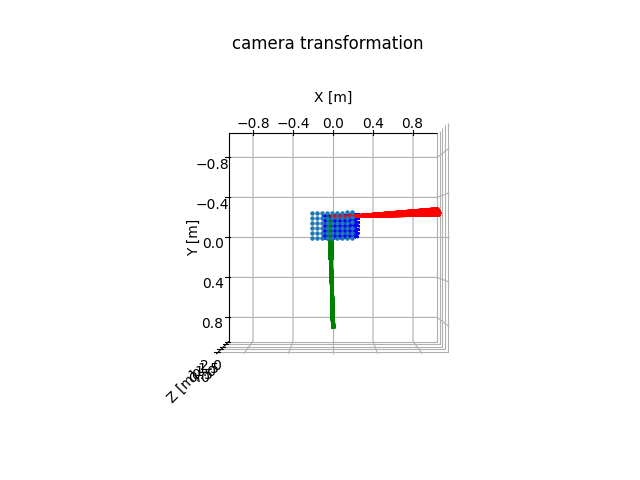

In [44]:
# Transformed Left Eye Camera

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left Poses
for T in filt_df['T_left_eye_chest_rgb']:
    T = np.matmul(T_chest_cam_ctr, T)
    T = np.matmul(T_gaze_ctr_left, T)
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

(-0.2, 2.0)

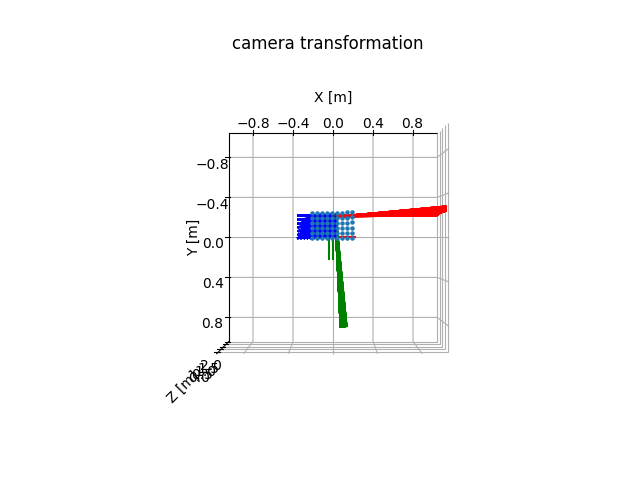

In [45]:
# Transformed Right Eye Camera

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left Poses
for T in filt_df['T_right_eye_chest_rgb']:
    T = np.matmul(T_chest_cam_ctr, T)
    T = np.matmul(T_gaze_ctr_right, T)
    ax = pr.plot_basis(ax, T[:3,:3], T[:3,-1], s=1.0)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])

(-0.2, 2.0)

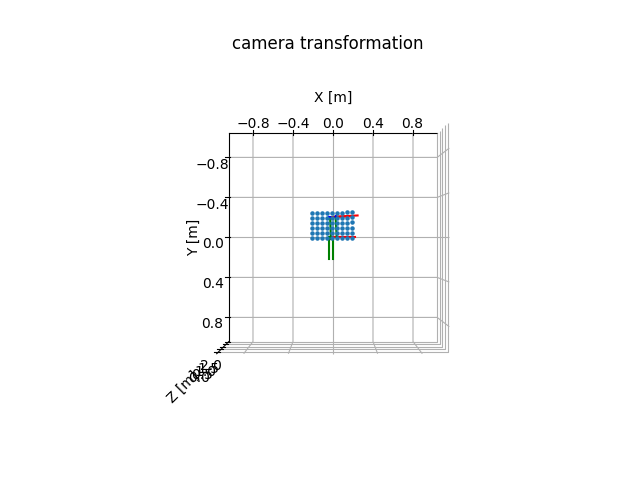

In [46]:
# Transformed Total Plot

# Plot 3D Axes

plt.figure()
ax = make_3d_axis(1, 111, unit="m")

# Plot Origin
ax = pr.plot_basis(ax, s=0.2)

# Plot 3D Chess Points
for x,y,z in depth_obj_pts:
    ax.scatter(x, y, z, color=colors[0], marker='.')

# Plot Chest Cam
ax = pr.plot_basis(ax, T_chest_cam_ctr[:3,:3], T_chest_cam_ctr[:3,-1], s=0.2)

# Plot Left 0 Pose
T_left = np.matmul(T_chest_cam_ctr, left_zero_T)
T_left = np.matmul(T_gaze_ctr_left, T_left)
ax = pr.plot_basis(ax, T_left[:3,:3], T_left[:3,-1], s=0.2)

# Plot Right 0 Pose
T_right = np.matmul(T_chest_cam_ctr, right_zero_T)
T_right = np.matmul(T_gaze_ctr_right, T_right)
ax = pr.plot_basis(ax, T_right[:3,:3], T_right[:3,-1], s=0.2)

ax.view_init(elev=-90, azim=-90)
ax.set_title("camera transformation")

ax.set_zlim([-0.2, 2.0])